Testing binary classifer on given data sets using 
https://github.com/nsansen/Quantum-Machine-Learning/blob/main/VCDR_ST2_-pi_pi.ipynb

Training the Training Data Set

In [1]:
import pennylane as qml

from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.init import strong_ent_layers_uniform
import torch
from torch.autograd import Variable
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd

# load the dataset
data_train=np.loadtxt('/Users/apple/variational_classifer/data/mock_train_set.csv', delimiter=',', skiprows=1)

X = data_train[:, 0:4]
y = data_train[:,4]

# normalize data
X = minmax_scale(X, feature_range=(0, np.pi))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# number of qubits is equal to the number of features
n_qubits = X.shape[1] 

# quantum device handle
dev = qml.device("default.qubit", wires=n_qubits)

# quantum circuit
@qml.qnode(dev)
def circuit(weights, x=None):
    AngleEmbedding(x, wires = range(n_qubits))
    StronglyEntanglingLayers(weights, wires = range(n_qubits))
    return qml.expval(qml.PauliZ(0))

# variational quantum classifier
def variational_classifier(theta, x=None):
    weights = theta[0]
    bias = theta[1]
    return circuit(weights, x=x) + bias

def cost(theta, X, expectations):
    e_predicted = \
        np.array([variational_classifier(theta, x=x) for x in X])
    loss = np.mean((e_predicted - expectations)**2)    
    return loss

# number of quantum layers
n_layers = 3


# convert classes to expectations: 0 to -1, 1 to +1
e_train = np.empty_like(y_train)
e_train[y_train == 0] = -1
e_train[y_train == 1] = +1

# select learning batch size
batch_size = 5

# calculate numbe of batches
batches = len(X_train) // batch_size

# select number of epochs
n_epochs = 5

# draw random quantum node weights
theta_weights = strong_ent_layers_uniform(n_layers, n_qubits, seed=42)
theta_bias = 0.0
theta_init = (theta_weights, theta_bias) # initial weights

# train the variational classifier
theta = theta_init


# build the optimizer object
pennylane_opt = GradientDescentOptimizer()


X_batches = np.array_split(np.arange(len(X_train)), batches)
lossplot = []
accuracytrainplot = []
accuracytestplot = []
for it, batch_index in enumerate(chain(*(n_epochs * [X_batches]))):
    # Update the weights by one optimizer step
    batch_cost = \
        lambda theta: cost(theta, X_train[batch_index], e_train[batch_index])
    theta = pennylane_opt.step(batch_cost, theta)

    if it % 10 == 0:
        expectations = np.array([variational_classifier(theta, x=x) for x in X_train])
        prob_class_one = (expectations + 1) / 2.0
        prob_class_one = pd.DataFrame.from_dict(prob_class_one)
        prob_class_one = prob_class_one.iloc[:, :]
        prob_class_one = prob_class_one[0].apply(lambda x: -1 if x <= 0.5 else 1)
        prob_class_one_T = prob_class_one.to_numpy()
           
        expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
        prob_class_one = (expectations + 1) / 2.0
        prob_class_one = pd.DataFrame.from_dict(prob_class_one)
        prob_class_one = prob_class_one.iloc[:, :]
        prob_class_one = prob_class_one[0].apply(lambda x: -1 if x <= 0.5 else 1)
        prob_class_one = prob_class_one.to_numpy()
        
        lossplot.append(cost(theta, X_train[batch_index], e_train[batch_index]))
        accuracytrainplot.append(metrics.accuracy_score(y_train, prob_class_one_T))
        accuracytestplot.append(metrics.accuracy_score(y_test, prob_class_one))
        
        #print("It",it+1,"out of",len(X_batches) *n_epochs)#
        print("It",it+1,"out of",len(X_batches) *n_epochs, "loss: ",cost(theta, X_train[batch_index], e_train[batch_index]),
        " : Acc train: ",round(metrics.accuracy_score(y_train, prob_class_one_T),2),
        " : Acc test : ",round(metrics.accuracy_score(y_test, prob_class_one),3))
        if metrics.accuracy_score(y_train, prob_class_one_T) >= 0.97:
                break

/var/folders/ct/dqdky4352zx_f2qfwpf8xq840000gn/T/ipykernel_19508/2279458971.py:75: UserWarning: The init module will be deprecated soon, since templates can now provide a method that returns the shape of parameter tensors.
  theta_weights = strong_ent_layers_uniform(n_layers, n_qubits, seed=42)
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 1 out of 240 loss:  1.1487327195665813  : Acc train:  0.11  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 11 out of 240 loss:  0.770301262510488  : Acc train:  0.11  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 21 out of 240 loss:  0.9478739163935364  : Acc train:  0.14  : Acc test :  0.217


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 31 out of 240 loss:  1.237958793996252  : Acc train:  0.13  : Acc test :  0.2


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 41 out of 240 loss:  0.7588542220861648  : Acc train:  0.14  : Acc test :  0.2


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 51 out of 240 loss:  0.8361703051592585  : Acc train:  0.14  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 61 out of 240 loss:  0.9193033757483793  : Acc train:  0.16  : Acc test :  0.167


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 71 out of 240 loss:  0.9041522090595302  : Acc train:  0.18  : Acc test :  0.2


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 81 out of 240 loss:  1.1263755214321236  : Acc train:  0.18  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 91 out of 240 loss:  1.1462142659074783  : Acc train:  0.2  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 101 out of 240 loss:  0.9731001734051239  : Acc train:  0.18  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 111 out of 240 loss:  0.7118959331233001  : Acc train:  0.18  : Acc test :  0.167


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 121 out of 240 loss:  1.0463884102269778  : Acc train:  0.17  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 131 out of 240 loss:  0.8456344758508152  : Acc train:  0.18  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 141 out of 240 loss:  0.8319460139399407  : Acc train:  0.17  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 151 out of 240 loss:  1.1361874127179514  : Acc train:  0.18  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 161 out of 240 loss:  0.6346593090124163  : Acc train:  0.19  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 171 out of 240 loss:  0.8264676883172519  : Acc train:  0.19  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 181 out of 240 loss:  0.9154739635417022  : Acc train:  0.2  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 191 out of 240 loss:  0.9244466441339864  : Acc train:  0.2  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 201 out of 240 loss:  0.872021809279642  : Acc train:  0.2  : Acc test :  0.167


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 211 out of 240 loss:  0.8937456949420808  : Acc train:  0.23  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 221 out of 240 loss:  0.8511398573530421  : Acc train:  0.19  : Acc test :  0.15


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 231 out of 240 loss:  0.7936058555201728  : Acc train:  0.24  : Acc test :  0.183


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


In [2]:
print(metrics.accuracy_score(y_train, prob_class_one_T))
print(metrics.accuracy_score(y_test, prob_class_one))
print(metrics.confusion_matrix(y_train, prob_class_one_T))
print(metrics.confusion_matrix(y_test, prob_class_one))

0.2375
0.18333333333333332
[[  0   0   0]
 [104   0  20]
 [ 59   0  57]]
[[ 0  0  0]
 [24  0  9]
 [16  0 11]]


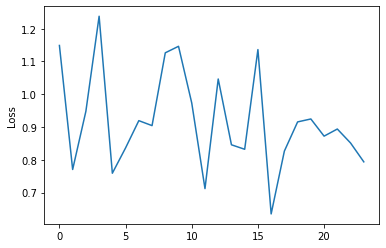

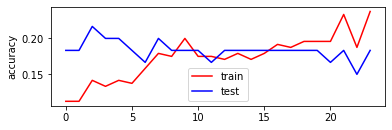

In [3]:
plt.plot(lossplot) #lets plot the second line
plt.ylabel('Loss')
plt.show()

plt.subplot(2,1,1)
plt.plot(accuracytrainplot,'r',label="train")
plt.plot(accuracytestplot,'b',label="test")
plt.ylabel('accuracy')
plt.legend()
plt.show()


Briniging the Testing Test

In [6]:
import pennylane as qml

from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.init import strong_ent_layers_uniform
import torch
from torch.autograd import Variable
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd

# load the dataset
data_test=np.loadtxt('/Users/apple/variational_classifer/data/mock_test_set.csv', delimiter=',', skiprows=1)

X = data_test[:, 0:4]
y = data_test[:,4]

# normalize data
X = minmax_scale(X, feature_range=(0, np.pi))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# number of qubits is equal to the number of features
n_qubits = X.shape[1] 

# quantum device handle
dev = qml.device("default.qubit", wires=n_qubits)

# quantum circuit
@qml.qnode(dev)
def circuit(weights, x=None):
    qml.AngleEmbedding(x, wires = range(n_qubits))
    StronglyEntanglingLayers(weights, wires = range(n_qubits))
    return qml.expval(qml.PauliZ(0))

# variational quantum classifier
def variational_classifier(theta, x=None):
    weights = theta[0]
    bias = theta[1]
    return circuit(weights, x=x) + bias

def cost(theta, X, expectations):
    e_predicted = \
        np.array([variational_classifier(theta, x=x) for x in X])
    loss = np.mean((e_predicted - expectations)**2)    
    return loss

# number of quantum layers
n_layers = 3


# convert classes to expectations: 0 to -1, 1 to +1
e_train = np.empty_like(y_train)
e_train[y_train == 0] = -1
e_train[y_train == 1] = +1

# select learning batch size
batch_size = 5

# calculate numbe of batches
batches = len(X_train) // batch_size

# select number of epochs
n_epochs = 5

# draw random quantum node weights
theta_weights = strong_ent_layers_uniform(n_layers, n_qubits, seed=42)
theta_bias = 0.0
theta_init = (theta_weights, theta_bias) # initial weights

# train the variational classifier
theta = theta_init


# build the optimizer object
pennylane_opt = GradientDescentOptimizer()


X_batches = np.array_split(np.arange(len(X_train)), batches)
lossplot = []
accuracytrainplot = []
accuracytestplot = []
for it, batch_index in enumerate(chain(*(n_epochs * [X_batches]))):
    # Update the weights by one optimizer step
    batch_cost = \
        lambda theta: cost(theta, X_train[batch_index], e_train[batch_index])
    theta = pennylane_opt.step(batch_cost, theta)

    if it % 10 == 0:
        expectations = np.array([variational_classifier(theta, x=x) for x in X_train])
        prob_class_one = (expectations + 1) / 2.0
        prob_class_one = pd.DataFrame.from_dict(prob_class_one)
        prob_class_one = prob_class_one.iloc[:, :]
        prob_class_one = prob_class_one[0].apply(lambda x: -1 if x <= 0.5 else 1)
        prob_class_one_T = prob_class_one.to_numpy()
           
        expectations = np.array([variational_classifier(theta, x=x) for x in X_test])
        prob_class_one = (expectations + 1) / 2.0
        prob_class_one = pd.DataFrame.from_dict(prob_class_one)
        prob_class_one = prob_class_one.iloc[:, :]
        prob_class_one = prob_class_one[0].apply(lambda x: -1 if x <= 0.5 else 1)
        prob_class_one = prob_class_one.to_numpy()
        
        lossplot.append(cost(theta, X_train[batch_index], e_train[batch_index]))
        accuracytrainplot.append(metrics.accuracy_score(y_train, prob_class_one_T))
        accuracytestplot.append(metrics.accuracy_score(y_test, prob_class_one))
        
        #print("It",it+1,"out of",len(X_batches) *n_epochs)#
        print("It",it+1,"out of",len(X_batches) *n_epochs, "loss: ",cost(theta, X_train[batch_index], e_train[batch_index]),
        " : Acc train: ",round(metrics.accuracy_score(y_train, prob_class_one_T),2),
        " : Acc test : ",round(metrics.accuracy_score(y_test, prob_class_one),3))
        if metrics.accuracy_score(y_train, prob_class_one_T) >= 0.97:
                break

/var/folders/ct/dqdky4352zx_f2qfwpf8xq840000gn/T/ipykernel_19508/232461720.py:75: UserWarning: The init module will be deprecated soon, since templates can now provide a method that returns the shape of parameter tensors.
  theta_weights = strong_ent_layers_uniform(n_layers, n_qubits, seed=42)
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 1 out of 95 loss:  1.0032604831775387  : Acc train:  0.09  : Acc test :  0.167


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 11 out of 95 loss:  1.268250427228119  : Acc train:  0.08  : Acc test :  0.208


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 21 out of 95 loss:  1.2363199918363967  : Acc train:  0.09  : Acc test :  0.208


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 31 out of 95 loss:  1.2884146395742087  : Acc train:  0.1  : Acc test :  0.208


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 41 out of 95 loss:  1.0574660445974686  : Acc train:  0.14  : Acc test :  0.25


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 51 out of 95 loss:  0.9831084720194074  : Acc train:  0.19  : Acc test :  0.25


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 61 out of 95 loss:  0.8056957613687563  : Acc train:  0.19  : Acc test :  0.292


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 71 out of 95 loss:  0.9877063843788532  : Acc train:  0.24  : Acc test :  0.333


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 81 out of 95 loss:  1.0819336901060825  : Acc train:  0.26  : Acc test :  0.333


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


It 91 out of 95 loss:  0.9670854144405767  : Acc train:  0.27  : Acc test :  0.333


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(
